In [1]:
pip install simplejson

     |████████████████████████████████| 130 kB 4.0 MB/s 


In [2]:
import os
import simplejson as json
import pandas as pd
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path_to_data_nico = "/content/drive/My Drive/Master Big Data /Tesis Big Data/Dataset_Facturas/Json_Facturas"
path_to_data_seba = "/content/drive/My Drive/Tesis Big Data/Dataset_Facturas/Json_Facturas"
path_to_data_nacho = "/content/drive/MyDrive/Dataset_Facturas/Json_Facturas"

path_to_data = path_to_data_nacho

In [8]:
#Carpetas a analizar
folders_to_process = ["La Comercial SRL","Modadol","Fernando Garcia","Ayala","Antilur","La Banderita","Los Nietitos","Marioni","Masula"]

In [10]:
MIN_CONF = 50

def remove_unconfident_words(doc_conf, doc_text):
    idx_to_remove = []
    for idx, conf in enumerate(doc_conf):
        if conf < MIN_CONF or doc_text[idx] == " ":
            idx_to_remove.append(idx)

    for index in sorted(idx_to_remove, reverse=True):
        del doc_text[index]

    return doc_text


# Open a file
dirs = os.listdir(path_to_data)
# This would print all the files and directories
df = pd.DataFrame()
data = []
for folder in dirs:
  if folder in folders_to_process:
    file_dirs = os.listdir(path_to_data+"/"+folder)
    for file in file_dirs:
      doc = open(f"{path_to_data}/{folder}/{file}")
      json_doc = json.load(doc)
      doc_conf = json_doc["OCR_Data"]["conf"]
      doc_text = json_doc["OCR_Data"]["text"]
      doc_text = remove_unconfident_words(doc_conf, doc_text)
      doc_text = " ".join(doc_text)
      data.append({"Client": folder, "OCR_text": doc_text})

df = df.append(data, ignore_index=True)
df["OCR_text"] = df["OCR_text"].replace("\s+", " ", regex=True).str.lower()

df["Category_Id"] = df['Client'].factorize()[0]

category_id_df = df[['Client', 'Category_Id']].drop_duplicates().sort_values('Category_Id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Category_Id', 'Client']].values)

In [11]:
print(df.head(-20))

       Client                                           OCR_text  Category_Id
0     Marioni  vendedor 23-01-2008 02.003823.0016. por 7696-r...            0
1     Marioni  | numero vendedor pimalan guerra 0 credito 540...            0
2     Marioni  cliente filco s.a total desc. tipo de docunent...            0
3     Marioni  para maquinaria agricola - tornille ferrecar l...            0
4     Marioni  cliente perez ortiz jose lte telefono 136276 i...            0
...       ...                                                ...          ...
4057  Modadol  axiun modadol srl 19000 12 efactura tel:228879...            7
4058  Modadol  modadol srl modadol srl montevideo ruta 8 km 2...            7
4059  Modadol  modadol srl modadol srl montev ideo ruta 8 km ...            7
4060  Modadol  modadol srl modadol srl montevideo ruta 8 km 2...            7
4061  Modadol  rut 214251330012 modadol srl efactura modadol ...            7

[4062 rows x 3 columns]


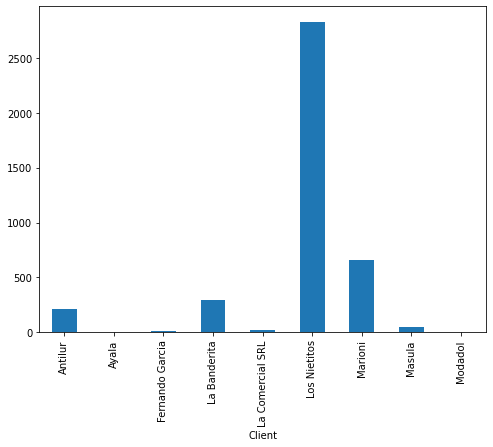

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Client').OCR_text.count().plot.bar(ylim=0)
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.OCR_text).toarray()
labels = df.Category_Id
features.shape

(4082, 29239)

In [14]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Client, Category_Id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == Category_Id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Client))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Antilur':
  . Most correlated unigrams:
. antilur
. cj
  . Most correlated bigrams:
. total gravado
. sub total


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Ayala':
  . Most correlated unigrams:
. ayala
. devoluciones
  . Most correlated bigrams:
. tipo venta
. moneda tc


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Fernando Garcia':
  . Most correlated unigrams:
. 28001
. fernando
  . Most correlated bigrams:
. destino entrega
. fernando garcia


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'La Banderita':
  . Most correlated unigrams:
. argentina
. basico
  . Most correlated bigrams:
. 380 grs
. iva basico


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'La Comercial SRL':
  . Most correlated unigrams:
. 212100540011
. mismo
  . Most correlated bigrams:
. la comercial
. en el


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Los Nietitos':
  . Most correlated unigrams:
. conforme
. recibi
  . Most correlated bigrams:
. recibi conforme
. 06 11


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Marioni':
  . Most correlated unigrams:
. condiciones
. recibi
  . Most correlated bigrams:
. recibi conforme
. 06 11


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Masula':
  . Most correlated unigrams:
. 90201851151
. masula
  . Most correlated bigrams:
. cae 90201851151
. imp 00
# 'Modadol':
  . Most correlated unigrams:
. 4563
. modadol
  . Most correlated bigrams:
. 4563 2015
. modadol srl


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['OCR_text'], df['Client'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

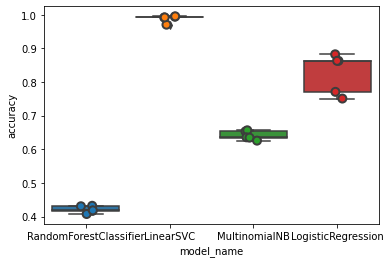

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1_macro', cv=CV) #macroaveragerecall f1
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

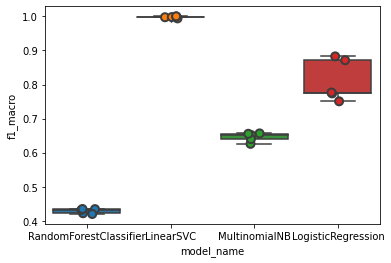

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1_macro', cv=CV) #macroaveragerecall f1
  for fold_idx, f1_macro in enumerate(accuracies):
    entries.append((model_name, fold_idx, f1_macro))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_macro'])
import seaborn as sns
sns.boxplot(x='model_name', y='f1_macro', data=cv_df)
sns.stripplot(x='model_name', y='f1_macro', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

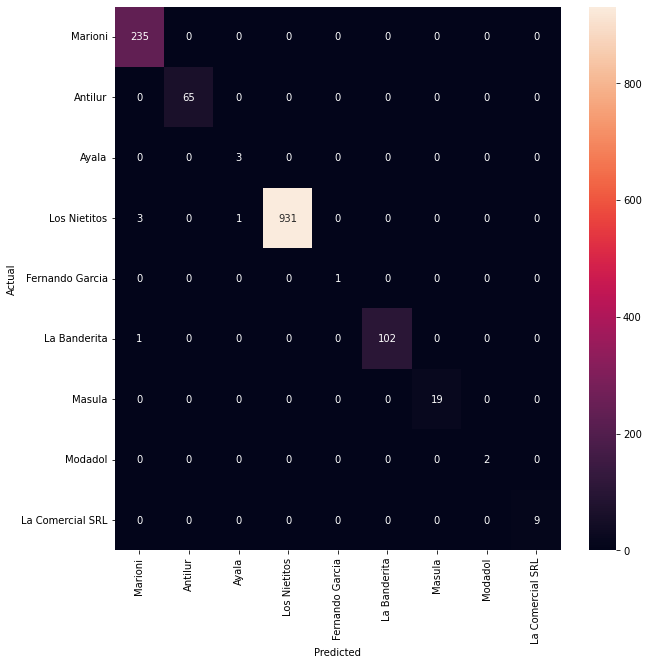

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Client.values, yticklabels=category_id_df.Client.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

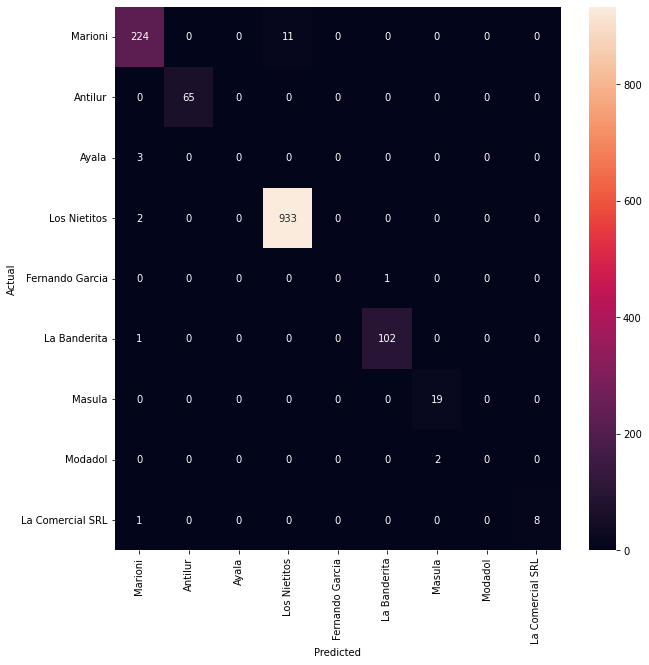

In [ ]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Client.values, yticklabels=category_id_df.Client.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()